In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def read_lammps_atomic_structure(filename):
    with open(filename, "r") as f:
        lines = f.read().splitlines()

    Lx = Ly = Lz = None
    atoms_start = None

    for i, line in enumerate(lines):
        if "xlo xhi" in line:
            a, b = line.split()[:2]
            Lx = float(b) - float(a)
        elif "ylo yhi" in line:
            a, b = line.split()[:2]
            Ly = float(b) - float(a)
        elif "zlo zhi" in line:
            a, b = line.split()[:2]
            Lz = float(b) - float(a)
        elif line.startswith("Atoms"):
            atoms_start = i + 2
            break

    if atoms_start is None:
        raise RuntimeError("Cannot find 'Atoms' section in data file.")

    positions = []
    for line in lines[atoms_start:]:
        line = line.strip()
        if not line:
            break
        if line[0].isalpha():
            break
        parts = line.split()
        x, y, z = map(float, parts[2:5])
        positions.append([x, y, z])

    positions = np.array(positions, dtype=float)
    box = np.array([Lx, Ly, Lz], dtype=float)
    return positions, box

def compute_pair_correlation(positions, box, dr=0.05, r_max=None):
    pos = np.array(positions, dtype=float)
    N = pos.shape[0]
    Lx, Ly, Lz = box
    volume = Lx * Ly * Lz
    rho = N / volume

    if r_max is None:
        r_max = 0.5 * min(box)

    nbins = int(r_max / dr)
    edges = np.linspace(0.0, r_max, nbins + 1)
    hist = np.zeros(nbins, dtype=float)

    for i in range(N):
        d = pos - pos[i]
        d[:, 0] -= Lx * np.round(d[:, 0] / Lx)
        d[:, 1] -= Ly * np.round(d[:, 1] / Ly)
        d[:, 2] -= Lz * np.round(d[:, 2] / Lz)
        r = np.linalg.norm(d, axis=1)
        cutoff = (r > 0.0) & (r < r_max)
        r_cutoff = r[cutoff]
        counts, _ = np.histogram(r_cutoff, bins=edges)
        hist += counts

    g_r = np.zeros(nbins, dtype=float)
    for i in range(nbins):
        r_in = edges[i]
        r_out = edges[i + 1]
        shell_vol = (4.0 / 3.0) * np.pi * (r_out**3 - r_in**3)
        n_ideal = N * rho * shell_vol
        if n_ideal > 0:
            g_r[i] = hist[i] / n_ideal

    r_centers = 0.5 * (edges[:-1] + edges[1:])
    return r_centers, g_r

def plot_gr(r, g_r, outfile):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    ax.plot(r, g_r, linewidth=2.0)
    ax.set_xlabel(r"$r \; (\mathrm{\AA})$", fontsize=12)
    ax.set_ylabel(r"g(r)", fontsize=12)
    ax.set_xlim(0, r.max())
    ax.set_ylim(bottom=0)
    ax.grid(True, which="both", linestyle=":", alpha=0.4)
    ax.tick_params(direction="in", top=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fig.tight_layout()
    fig.savefig(outfile, dpi=300)
    plt.close(fig)

def legal_kvecs(maxn, L):
    k0 = 2.0 * np.pi / float(L)
    n = np.arange(-maxn, maxn + 1)
    nx, ny, nz = np.meshgrid(n, n, n, indexing="ij")
    kvecs = np.column_stack([nx.ravel(), ny.ravel(), nz.ravel()])
    kvecs = kvecs[np.any(kvecs != 0, axis=1)]
    return k0 * kvecs

def calc_rhok(kvecs, pos):
    phase = kvecs @ pos.T
    rhok = np.exp(-1j * phase).sum(axis=1)
    return rhok

def calc_Sk(kvecs, pos):
    N = pos.shape[0]
    rhok = calc_rhok(kvecs, pos)
    Sk = (rhok * np.conjugate(rhok)).real / N
    return Sk

def compute_structure_factor(positions, box, maxn_k=10, k_cut=None, nbins_k=40):
    L = float(min(box))
    kvecs_all = legal_kvecs(maxn_k, L)
    k_mag_all = np.linalg.norm(kvecs_all, axis=1)

    if k_cut is not None:
        mask = k_mag_all < k_cut
        kvecs_all = kvecs_all[mask]
        k_mag_all = k_mag_all[mask]

    Sk_all = calc_Sk(kvecs_all, positions)

    kmin, kmax = k_mag_all.min(), k_mag_all.max()
    bins = np.linspace(kmin, kmax, nbins_k + 1)
    bin_idx = np.digitize(k_mag_all, bins) - 1

    k_bin_list = []
    Sk_bin_list = []
    for ib in range(nbins_k):
        mask_b = bin_idx == ib
        if np.any(mask_b):
            k_bin_list.append(k_mag_all[mask_b].mean())
            Sk_bin_list.append(Sk_all[mask_b].mean())

    k_bin = np.array(k_bin_list)
    Sk_bin = np.array(Sk_bin_list)
    return k_bin, Sk_bin

def plot_Sk(k, Sk, outfile):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    ax.plot(k, Sk, linewidth=2.0)
    ax.set_xlabel(r"$k \; (\mathrm{\AA^{-1}})$", fontsize=12)
    ax.set_ylabel(r"$S(k)$", fontsize=12)
    ax.set_xlim(0, k.max() * 1.05)
    ax.set_ylim(0, Sk.max() * 1.15)
    ax.grid(True, which="both", linestyle=":", alpha=0.4)
    ax.tick_params(direction="in", top=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fig.tight_layout()
    fig.savefig(outfile, dpi=300)
    plt.close(fig)

def process_final_structure_file(path, dr=0.05, maxn_k=10, nbins_k=40, k_cut=None):
    positions, box = read_lammps_atomic_structure(path)
    stem = os.path.splitext(os.path.basename(path))[0]

    r, g_r = compute_pair_correlation(positions, box, dr=dr)
    np.savetxt(
        f"gr_{stem}.dat",
        np.column_stack((r, g_r)),
        header="r(Å)   g(r)   (FINAL_STRUCTURE)",
    )
    plot_gr(r, g_r, outfile=f"Pair_Correlation_{stem}.png")

    k_bin, Sk_bin = compute_structure_factor(
        positions, box, maxn_k=maxn_k, k_cut=k_cut, nbins_k=nbins_k
    )
    np.savetxt(
        f"Sk_{stem}.dat",
        np.column_stack((k_bin, Sk_bin)),
        header="k(1/Å)   S(k)   (FINAL_STRUCTURE)",
    )
    plot_Sk(k_bin, Sk_bin, outfile=f"Structure_Factor_{stem}.png")

def main():
    root = "."
    files = [
        f for f in os.listdir(root)
        if os.path.isfile(os.path.join(root, f)) and f.startswith("FINAL_STRUCTURE")
    ]
    files.sort()
    for fname in files:
        path = os.path.join(root, fname)
        process_final_structure_file(path)

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np

timestep_ps     = 0.001    
hop_threshold_A = 1.0      
dead_frames     = 3        
jump_distance_A = 2.35     
dump_name       = "state_dump"
max_frames      = 20000


def analyze_hops_from_dump(path, timestep_ps, hop_threshold_A, dead_frames,
                           max_frames=None):
    """
    Read a LAMMPS dump and count hops for:
      - all atoms
      - atom type 1
      - atom type 2
    Returns:
      natoms_total, total_hops_all, total_time_ps,
      natoms_type1, hops_type1,
      natoms_type2, hops_type2
    """
    with open(path, "r") as f:
        frame_idx = 0
        natoms = None
        rprev_wrap = None
        rprev_unwrap = None
        last_hop_frame = None
        L = None
        first_step = None
        last_step = None
        total_hops_all = 0


        types = None
        hops_type1 = 0
        hops_type2 = 0

        while True:
            if max_frames is not None and frame_idx >= max_frames:
                print(f"  Reached max_frames={max_frames}, stopping read for this dump.")
                break

            line = f.readline()
            if not line:
                break  

            if not line.startswith("ITEM: TIMESTEP"):
                raise RuntimeError(f"Expected 'ITEM: TIMESTEP', got: {line.strip()}")

            step = int(f.readline().strip())
            if first_step is None:
                first_step = step
            last_step = step

            line = f.readline().strip()
            if not line.startswith("ITEM: NUMBER OF ATOMS"):
                raise RuntimeError("Expected 'ITEM: NUMBER OF ATOMS'")
            n = int(f.readline().strip())
            if natoms is None:
                natoms = n
            elif n != natoms:
                raise RuntimeError(f"Inconsistent natoms: previously {natoms}, now {n}")

          
            line = f.readline().strip()
            if not line.startswith("ITEM: BOX BOUNDS"):
                raise RuntimeError("Expected 'ITEM: BOX BOUNDS'")
            bounds = []
            for _ in range(3):
                parts = f.readline().split()
                bounds.append((float(parts[0]), float(parts[1])))
            Lx, Ly, Lz = [hi - lo for lo, hi in bounds]
            if L is None:
                L = np.array([Lx, Ly, Lz], dtype=float)

            header = f.readline().split()
            if header[0] != "ITEM:" or header[1] != "ATOMS":
                raise RuntimeError("Expected 'ITEM: ATOMS' header")
            labels = header[2:]

            try:
                ix = labels.index("x")
                iy = labels.index("y")
                iz = labels.index("z")
            except ValueError:
                raise RuntimeError("Dump must contain x y z columns")

            id_idx = labels.index("id")   if "id"   in labels else None
            tp_idx = labels.index("type") if "type" in labels else None
            if tp_idx is None:
                raise RuntimeError("Dump must contain 'type' column to separate elements")

            coords_wrapped = np.zeros((natoms, 3), float)
            if types is None:
                types = np.zeros(natoms, dtype=int)


            for i in range(n):
                cols = f.readline().split()
                atom_id = int(cols[id_idx]) - 1 if id_idx is not None else i
                atype   = int(cols[tp_idx])
                types[atom_id] = atype
                coords_wrapped[atom_id, 0] = float(cols[ix])
                coords_wrapped[atom_id, 1] = float(cols[iy])
                coords_wrapped[atom_id, 2] = float(cols[iz])

            if frame_idx == 0:
              
                rprev_wrap   = coords_wrapped.copy()
                rprev_unwrap = coords_wrapped.copy()
                last_hop_frame = -np.ones(natoms, dtype=int)
            else:
   
                delta = coords_wrapped - rprev_wrap
                for dim, Ldim in enumerate(L):
                    big_pos = delta[:, dim] >  0.5 * Ldim
                    big_neg = delta[:, dim] < -0.5 * Ldim
                    delta[big_pos, dim] -= Ldim
                    delta[big_neg, dim] += Ldim
                rcurr_unwrap = rprev_unwrap + delta

     
                dr = rcurr_unwrap - rprev_unwrap
                dr_mag = np.linalg.norm(dr, axis=1)

                candidates = dr_mag >= hop_threshold_A
                can_hop = (frame_idx - last_hop_frame) > dead_frames
                new_hops = candidates & can_hop

       
                nhops_frame_all = int(np.count_nonzero(new_hops))
                total_hops_all += nhops_frame_all

     
                mask_t1 = (types == 1)
                mask_t2 = (types == 2)
                hops_type1 += int(np.count_nonzero(new_hops & mask_t1))
                hops_type2 += int(np.count_nonzero(new_hops & mask_t2))

         
                last_hop_frame[new_hops] = frame_idx

                rprev_wrap   = coords_wrapped
                rprev_unwrap = rcurr_unwrap

            frame_idx += 1

            if frame_idx % 1000 == 0:
                print(f"  ...read {frame_idx} frames so far")

    if first_step is None or last_step is None:
        raise RuntimeError("No frames read from dump")

    total_time_ps = (last_step - first_step) * timestep_ps

    # natoms by type (assuming types don’t change)
    natoms_type1 = int(np.sum(types == 1)) if types is not None else 0
    natoms_type2 = int(np.sum(types == 2)) if types is not None else 0

    return (natoms, total_hops_all, total_time_ps,
            natoms_type1, hops_type1,
            natoms_type2, hops_type2)


def compute_D_from_hops(natoms, total_hops, total_time_ps, jump_distance_A):
    """
    Turn hop count into D, following your formula.
    """
    if total_hops == 0 or total_time_ps <= 0.0 or natoms <= 0:
        return 0.0, 0.0, 0.0

    a2_A2 = jump_distance_A ** 2
    D_A2_per_ps = a2_A2 * total_hops / (6.0 * natoms * total_time_ps)

    T_s = total_time_ps * 1e-12          # ps -> s
    a_m = jump_distance_A * 1e-10        # Å -> m
    D_m2_per_s = a_m ** 2 * total_hops / (6.0 * natoms * T_s)
    D_cm2_per_s = D_m2_per_s * 1e4

    return D_A2_per_ps, D_m2_per_s, D_cm2_per_s


def main():

    root_dir = os.path.expanduser(
        "~/Downloads/LAMMPS_SIMULATION_CONTAINMINANT_485"
    )


    print(f"Root folder: {root_dir}")


    dump_files = [
        f for f in sorted(os.listdir(root_dir))
        if os.path.isfile(os.path.join(root_dir, f))
        and f.startswith("state_dump_")
    ]

    if not dump_files:
        print("No files starting with 'state_dump_' were found.")
        return

    print("Found dump files:")
    for f in dump_files:
        print("  -", f)


    out_lines = []
    header = (
        "label group natoms total_hops total_time_ps "
        "D_A2_per_ps D_m2_per_s D_cm2_per_s"
    )
    out_lines.append(header)


    for dump_file in dump_files:
        dump_path = os.path.join(root_dir, dump_file)
   
        label = dump_file.replace("state_dump_", "")

        print(f"\nProcessing {dump_file} (label={label}) ...")
        (natoms_all, total_hops_all, total_time_ps,
         natoms_1, hops_1,
         natoms_2, hops_2) = analyze_hops_from_dump(
            dump_path,
            timestep_ps=timestep_ps,
            hop_threshold_A=hop_threshold_A,
            dead_frames=dead_frames,
            max_frames=max_frames,
        )


        D_all_A2_ps, D_all_m2_s, D_all_cm2_s = compute_D_from_hops(
            natoms_all, total_hops_all, total_time_ps, jump_distance_A
        )
        out_lines.append(
            f"{label} all {natoms_all} {total_hops_all} "
            f"{total_time_ps:.4f} {D_all_A2_ps:.6e} "
            f"{D_all_m2_s:.6e} {D_all_cm2_s:.6e}"
        )


        if natoms_1 > 0:
            D1_A2_ps, D1_m2_s, D1_cm2_s = compute_D_from_hops(
                natoms_1, hops_1, total_time_ps, jump_distance_A
            )
            out_lines.append(
                f"{label} type1 {natoms_1} {hops_1} "
                f"{total_time_ps:.4f} {D1_A2_ps:.6e} "
                f"{D1_m2_s:.6e} {D1_cm2_s:.6e}"
            )


        if natoms_2 > 0:
            D2_A2_ps, D2_m2_s, D2_cm2_s = compute_D_from_hops(
                natoms_2, hops_2, total_time_ps, jump_distance_A
            )
            out_lines.append(
                f"{label} type2 {natoms_2} {hops_2} "
                f"{total_time_ps:.4f} {D2_A2_ps:.6e} "
                f"{D2_m2_s:.6e} {D2_cm2_s:.6e}"
            )

        print("  Done.")


    out_path = os.path.join(root_dir, "D_results_hop_multi.txt")
    with open(out_path, "w") as f:
        f.write("\n".join(out_lines))

    print(f"\nSaved hop-based diffusion results to:\n{out_path}")



if __name__ == "__main__":
    main()


Root folder: /Users/zhy/Downloads/LAMMPS_SIMULATION_CONTAINMINANT_485
Found dump files:
  - state_dump_T1000K_C1
  - state_dump_T1000K_C10
  - state_dump_T1000K_C20
  - state_dump_T1000K_C5
  - state_dump_T1100K_C1
  - state_dump_T1100K_C10
  - state_dump_T1100K_C20
  - state_dump_T1100K_C5
  - state_dump_T1200K_C1
  - state_dump_T1200K_C10
  - state_dump_T1200K_C20
  - state_dump_T1200K_C5
  - state_dump_T700K_C1
  - state_dump_T700K_C10
  - state_dump_T700K_C20
  - state_dump_T700K_C5
  - state_dump_T800K_C1
  - state_dump_T800K_C10
  - state_dump_T800K_C20
  - state_dump_T800K_C5
  - state_dump_T900K_C1
  - state_dump_T900K_C10
  - state_dump_T900K_C20
  - state_dump_T900K_C5

Processing state_dump_T1000K_C1 (label=T1000K_C1) ...
  ...read 1000 frames so far
  ...read 2000 frames so far
  ...read 3000 frames so far
  ...read 4000 frames so far
  ...read 5000 frames so far
  ...read 6000 frames so far
  ...read 7000 frames so far
  ...read 8000 frames so far
  ...read 9000 frames so 

/var/folders/qw/b236xsjs7wx5vfc_p0bz9dfm0000gn/T/ipykernel_96854/3878680087.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(RESULTS_TXT, delim_whitespace=True)


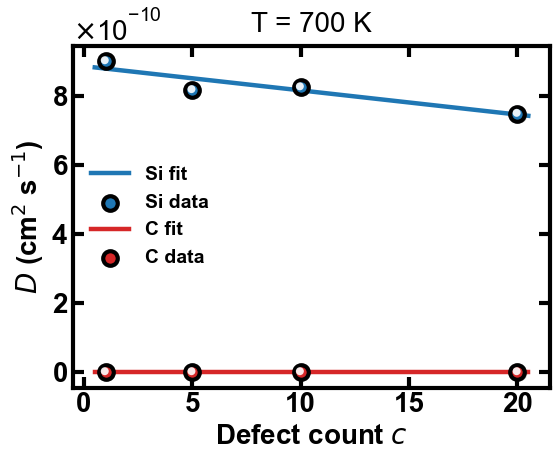

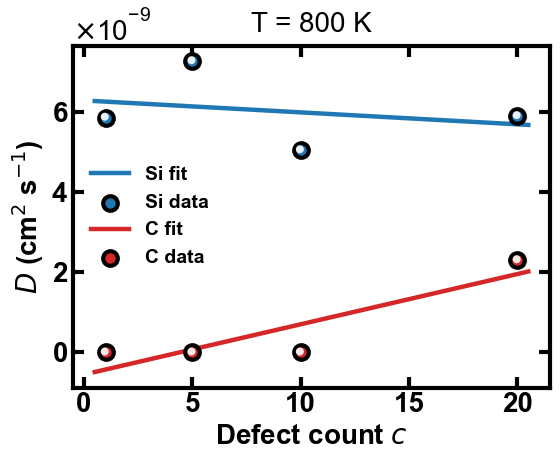

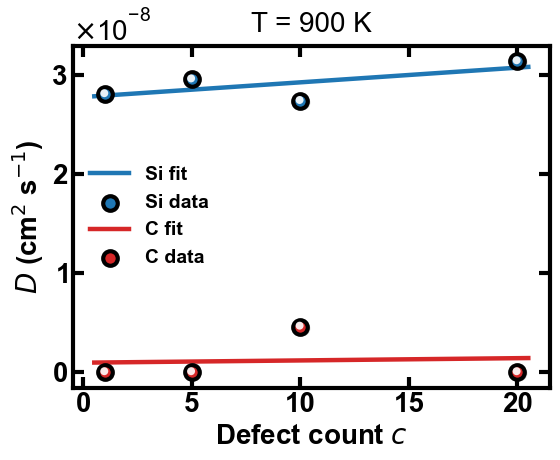

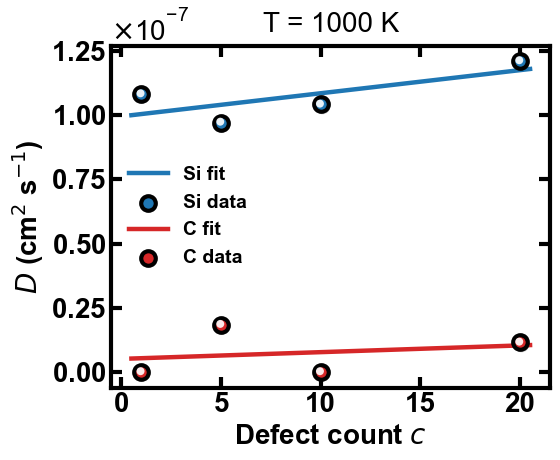

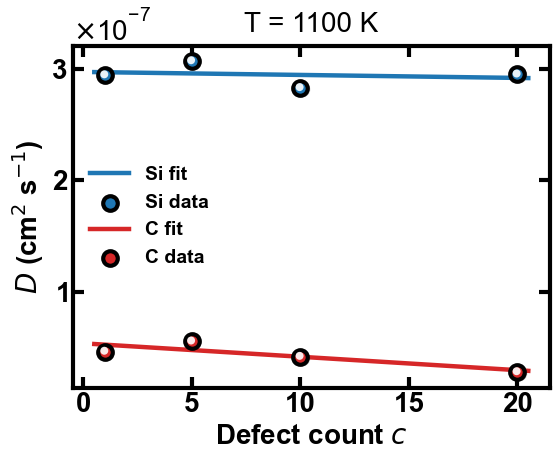

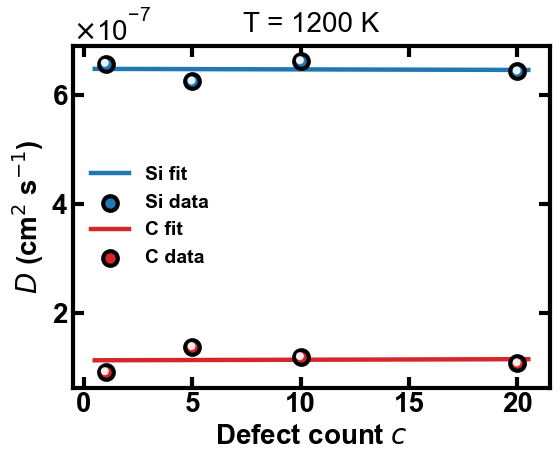


=== Arrhenius activation energies Q (eV) ===
Si, c = 1: Q = 0.965 eV (slope = -1.119e+04)


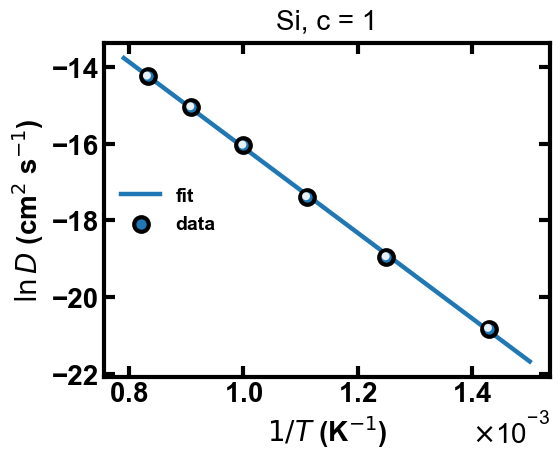

Si, c = 5: Q = 0.958 eV (slope = -1.112e+04)


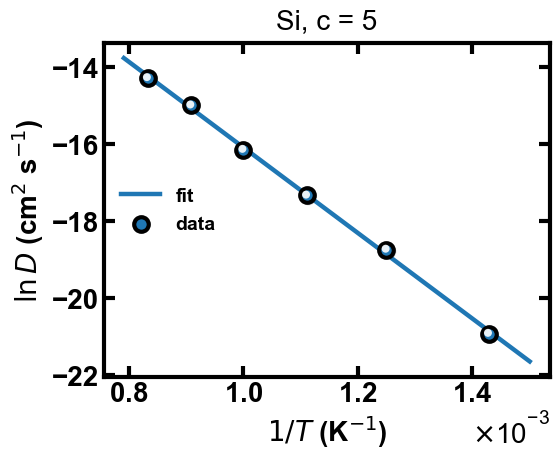

Si, c = 10: Q = 0.981 eV (slope = -1.138e+04)


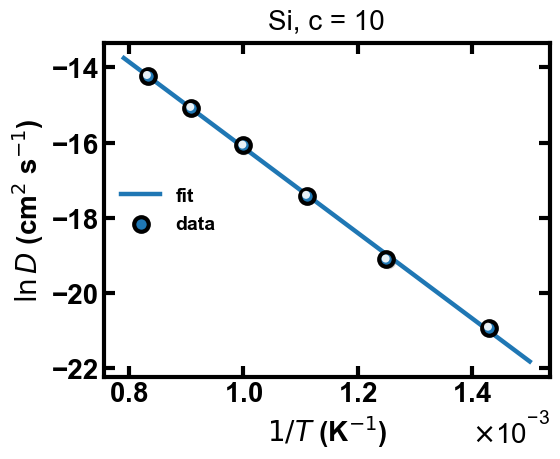

Si, c = 20: Q = 0.987 eV (slope = -1.145e+04)


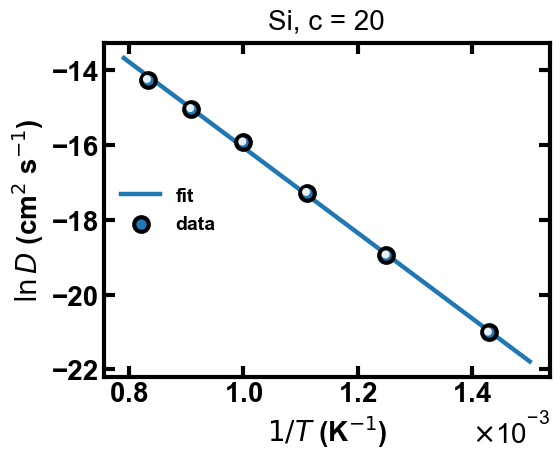

C, c = 1: Q = 0.788 eV (slope = -9.150e+03)


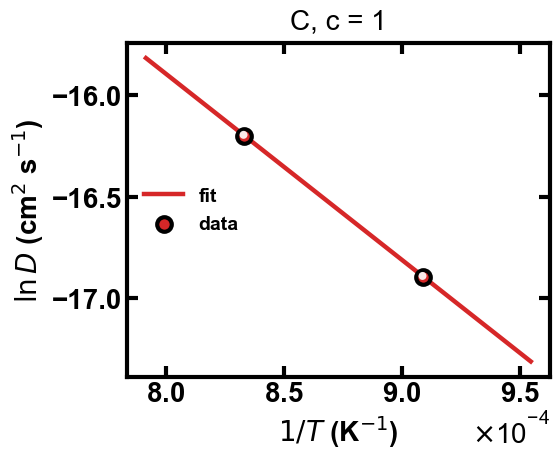

C, c = 5: Q = 1.042 eV (slope = -1.209e+04)


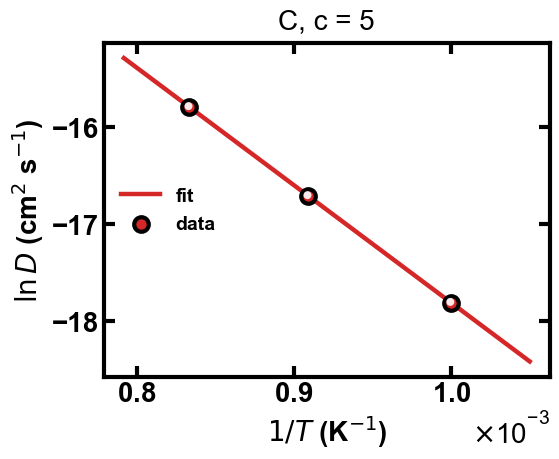

C, c = 10: Q = 0.996 eV (slope = -1.155e+04)


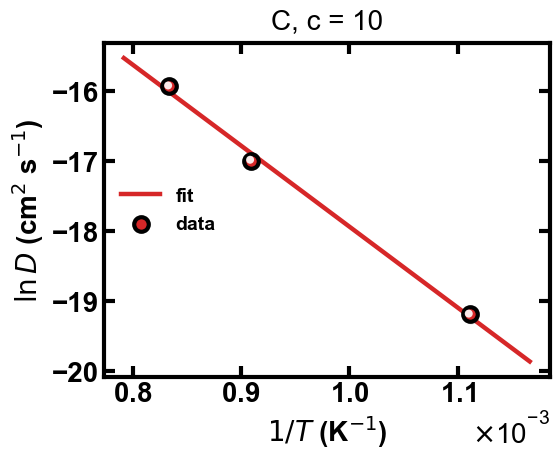

C, c = 20: Q = 0.746 eV (slope = -8.653e+03)


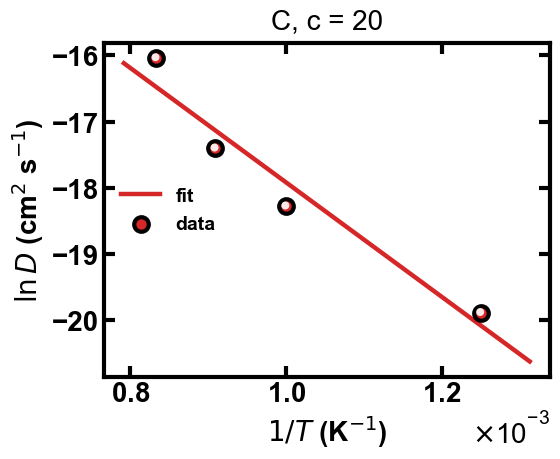

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from matplotlib.ticker import MultipleLocator, ScalarFormatter

RESULTS_TXT = "D_results_hop_multi.txt"
OUT_DIR = "fig_D_from_hop"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- load and parse ----------

df = pd.read_csv(RESULTS_TXT, delim_whitespace=True)

# label looks like "T1200K_C20"
df["T_K"]  = df["label"].str.extract(r"T(\d+)K")[0].astype(float)
df["conc"] = df["label"].str.extract(r"C(\d+)")[0].astype(float)

# group is "all", "type1", "type2"
df["species"] = df["group"].str.strip().str.lower()

# use D in cm^2/s
df["D"] = df["D_cm2_per_s"].astype(float)

plt.rcParams.update({
    "font.sans-serif": ["Arial", "DejaVu Sans"],
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "axes.labelweight": "bold",
    "axes.linewidth": 3,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 14
})

def glossy_scatter(ax, x, y, color, size=110, edge="k", label=None, z=5):
    shadow_tf = offset_copy(ax.transData, fig=ax.figure, x=0.8, y=-0.8, units="points")
    ax.scatter(x, y, s=size * 1.15, c="0.3", alpha=0.25, linewidths=0,
               transform=shadow_tf, zorder=z - 2)
    ax.scatter(x, y, s=size, c=color, edgecolors=edge, linewidths=3,
               zorder=z - 1, label=label)
    hl_tf = offset_copy(ax.transData, fig=ax.figure, x=-0.6, y=0.6, units="points")
    ax.scatter(x, y, s=size * 0.3, c="w", edgecolors="none", alpha=0.9,
               transform=hl_tf, zorder=z)

# map to Si / C
species_colors = {"type1": "tab:blue", "type2": "tab:red"}
species_labels = {"type1": "Si", "type2": "C"}

temps = sorted(df["T_K"].unique())
conc_list = sorted(df["conc"].unique())

# ---------- D vs concentration at fixed T ----------

for T in temps:
    dT = df[df["T_K"] == T]
    fig, ax = plt.subplots(figsize=(6, 5))

    for sp in ["type1", "type2"]:
        dS = dT[dT["species"] == sp].sort_values("conc")
        if dS.empty:
            continue

        x = dS["conc"].values
        y = dS["D"].values

        # linear fit: D = m c + b
        m, b = np.polyfit(x, y, 1)
        x_line = np.linspace(x.min() - 0.5, x.max() + 0.5, 200)
        y_line = m * x_line + b

        ax.plot(x_line, y_line, color=species_colors[sp], lw=3.2,
                label=f"{species_labels[sp]} fit", zorder=1)
        glossy_scatter(ax, x, y, color=species_colors[sp],
                       label=f"{species_labels[sp]} data", z=5)

    ax.set_title(f"T = {int(T)} K", pad=10)
    ax.set_xlabel("Defect count $c$", fontweight="bold")
    ax.set_ylabel(r"$D$ (cm$^{2}$ s$^{-1}$)", fontweight="bold")

    fmt_y = ScalarFormatter(useMathText=True)
    fmt_y.set_scientific(True)
    fmt_y.set_powerlimits((-2, 2))
    ax.yaxis.set_major_formatter(fmt_y)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2))

    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.tick_params(axis="both", width=3, length=8,
                   direction="in", top=True, right=True)
    for spn in ax.spines.values():
        spn.set_linewidth(3)
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_fontweight("bold")

    leg = ax.legend(frameon=False, loc="center left")
    for t_ in leg.get_texts():
        t_.set_fontweight("bold")

    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"D_vs_conc_{int(T)}K.png"), dpi=600)
    plt.show()

# ---------- Arrhenius plots ----------

k_B_eV = 8.617333262e-5

print("\n=== Arrhenius activation energies Q (eV) ===")
for sp in ["type1", "type2"]:
    for c in conc_list:
        d = df[(df["species"] == sp) & (df["conc"] == c)].sort_values("T_K")
        d = d[d["D"] > 0]   # avoid log(0)

        if d.empty or len(d) < 2:
            continue

        Tvals = d["T_K"].values
        Dvals = d["D"].values
        x = 1.0 / Tvals
        y = np.log(Dvals)

        slope, intercept = np.polyfit(x, y, 1)
        Q_eV = -slope * k_B_eV
        print(f"{species_labels[sp]}, c = {int(c)}: Q = {Q_eV:.3f} eV (slope = {slope:.3e})")

        x_line = np.linspace(x.min() * 0.95, x.max() * 1.05, 200)
        y_line = slope * x_line + intercept

        fig, ax = plt.subplots(figsize=(6, 5))
        ax.plot(x_line, y_line, color=species_colors[sp], lw=3.2,
                label="fit", zorder=1)
        glossy_scatter(ax, x, y, color=species_colors[sp],
                       label="data", z=5)

        ax.set_title(f"{species_labels[sp]}, c = {int(c)}", pad=10)
        ax.set_xlabel(r"$1/T$ (K$^{-1}$)", fontweight="bold")
        ax.set_ylabel(r"$\ln D$ (cm$^{2}$ s$^{-1}$)", fontweight="bold")

        fmt_x = ScalarFormatter(useMathText=True)
        fmt_x.set_scientific(True)
        fmt_x.set_powerlimits((-3, -2))
        ax.xaxis.set_major_formatter(fmt_x)
        ax.ticklabel_format(axis="x", style="sci", scilimits=(-3, -2))

        ax.tick_params(axis="both", width=3, length=8,
                       direction="in", top=True, right=True)
        for spn in ax.spines.values():
            spn.set_linewidth(3)
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_fontweight("bold")

        leg = ax.legend(frameon=False, loc="center left")
        for t_ in leg.get_texts():
            t_.set_fontweight("bold")

        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, f"Arrhenius_{sp}_c{int(c)}.png"), dpi=600)
        plt.show()
